In [1]:
# -- For Google Colab
#! pip install -q "gwpy==1.0.0" "gwosc==0.4.3"
%matplotlib inline

## Q-transforms in GWpy

In parts [1](./1 - Open Data access with GWpy.ipynb) and [2](./2 - Filtering data with GWpy.ipynb) we have seen how to load data, filter in the frequency-domain and the time-domain, and make lots of plots.

The filtering we did required a fair amount of knowledge of what sorts of noises are present in the LIGO detectors, and what frequencies are relevant for detecting a gravitational-wave signal from a binary black hole merger.

In this section, we will see how we can use a special filter called a Q-transform to create a time-frequency representation of our data that allows use to pick out features at different frequencies, and how they evolve over time, without much prior knowledge of the signal morphology.

See [this article](https://doi.org/10.1088/0264-9381/21/20/024) for more details on the Q-transform and its application to gravitational-wave data.

So, lets reload our data, this time using GW170817:

In [2]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

gps = event_gps('GW170817')
segment = (int(gps) - 30, int(gps) + 2)
hdata = TimeSeries.fetch_open_data('H1', *segment, tag='CLN', verbose=True, cache=True)

Fetched 1 URLs from www.gw-osc.org for [1187008852 .. 1187008884))
Reading data... [Done]


We can now use the `q_transform()` method of the `hdata` `TimeSeries` to create our time-frequency representation (as a [spectrogram](https://gwpy.github.io/docs/stable/spectrogram/)).

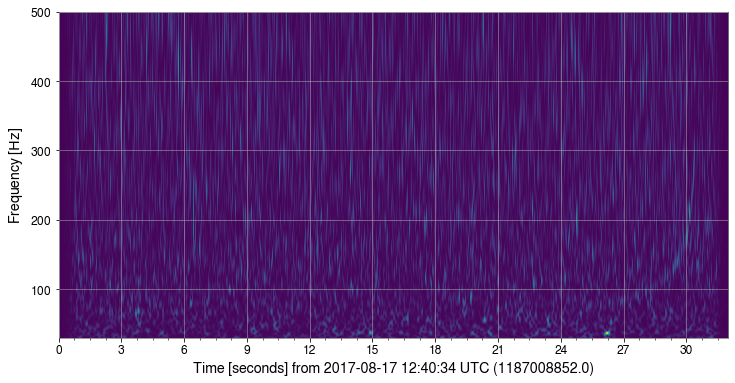

In [3]:
hq = hdata.q_transform(frange=(30, 500))
plot = hq.plot()

Here we see the vague track of a binary neutron star merger, but it looks... smudgy. This is because the highest energy time-frequency pixel was found with a low Q value (Q~=5), which doesn't work well for such long-duration signals as a binary neutron star.
We can rerun the Q-transform using a narrow Q range at higher Q (Q~=100), to resolve the BNS track much better:

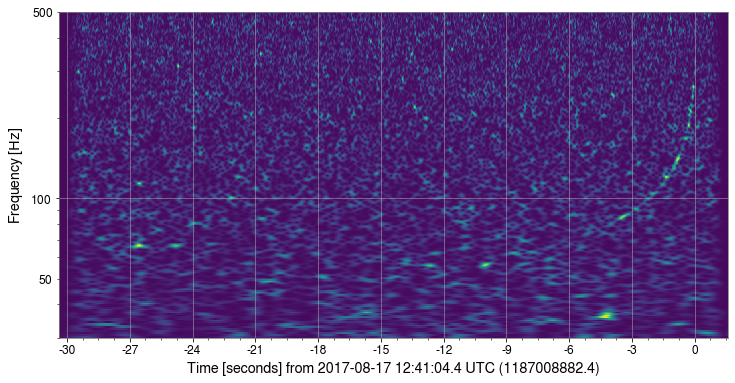

In [4]:
hq = hdata.q_transform(frange=(30, 500), qrange=(100, 110))
plot = hq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')

Now we see the beautiful, clear track of a BNS merger, visible from about -4 seconds (maye -10 if you squint), all the way through to the merger at T=0.

We can repeat the exercise using LIGO-Livingston data to see something even more remarkable.
First we download and filter the Livingston data:

In [5]:
ldata = TimeSeries.fetch_open_data('L1', *segment, tag='CLN', verbose=True)

Fetched 1 URLs from www.gw-osc.org for [1187008852 .. 1187008884))
Reading data... [Done]


We can now process the `ldata` `TimeSeries` using a Q-transform, using the same parameters we used for the Hanford Q-transform:

In [6]:
lq = ldata.q_transform(frange=(30, 500), qrange=(100, 110))

Now we can make a new figure including data from both interferometers:

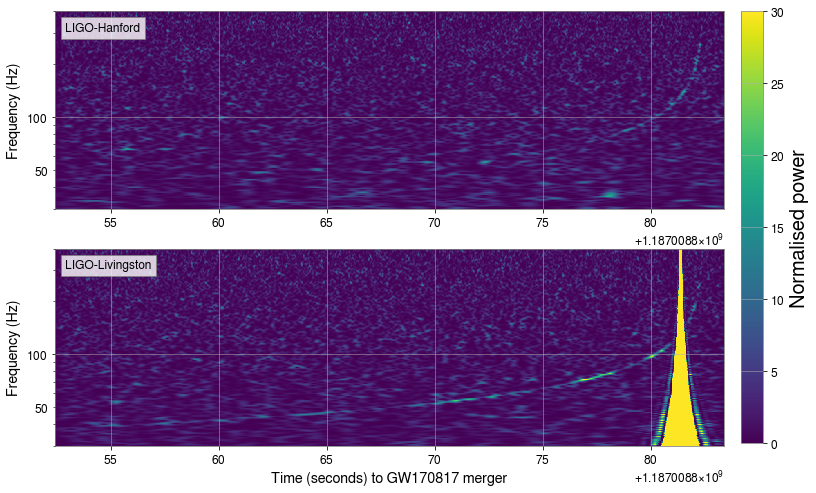

In [7]:
# create the figure and plot the data on separate axes
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

for ax, data, xlabel, detlabel in [(axs[0], hq, '', 'LIGO-Hanford'),(axs[1], lq, 'Time (seconds) to GW170817 merger', 'LIGO-Livingston')]:
    im=ax.pcolormesh(data, vmin=0, vmax=30)
    
    # add hidden elements that we can use for labelling
    ax.plot(gps, 0, label=detlabel, visible=False)
    ax.legend(loc='upper left', handlelength=0, handletextpad=0)

    # format the axes
    ax.set_epoch(gps)
    ax.set_xlim(gps-30, gps+1)
    ax.set_yscale('log')
    ax.set_ylim(30, 400)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency (Hz)')

# finalise
cax = plt.axes([0.92, 0.13, 0.025, 0.75])
cbar=fig.colorbar(im, cax=cax)
cbar.set_label('Normalised power',size='20')
# Notice that there is a glitch that overlapped with the signal in LIGO-Livingston data 

Now we can a BNS merge all the way back to T=-25 seconds in LIGO-Livingston data!

This is basically the same procedure (and the same code) that was used to produce Figure 1 of the BNS discovery article '_Observation of Gravitational Waves from a Binary Neutron Star Inspiral_' [[link](https://doi.org/10.1103/PhysRevLett.119.161101)]